# Task 2: Data Profiling, Cleaning & EDA
**Objective:** Profile, clean, and explore the solar dataset for Benin so it’s ready for comparison and region-ranking tasks.

This notebook includes:
- Summary statistics and missing-value report
- Outlier detection and cleaning
- Time series analysis
- Correlation and scatter plots
- Wind and temperature analysis
- Bubble charts

## Importing the dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Loading the Data

In [ ]:
# Set both plotting and display settings
import pandas as pd

# Load dataset
df = pd.read_csv(r"D:\Python\Week_01\data\data\benin-malanville.csv")

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 10)

In [ ]:
# Show basic info
print(f"Dataset shape: {df.shape}")
df.info()

In [ ]:
#  Display the first 5 rows
print("\nFirst 5 rows:")
display(df.head())

In [ ]:
# Display the last 10 rows
print("\nLast 10 rows:")
display(df.tail(10))

In [ ]:
# Display 10 random sample rows
print("\nRandom sample of 10 rows:")
display(df.sample(10, random_state=42))

In [ ]:
# Summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
display(df.describe())

In [ ]:
# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Percentage of missing values per column
null_percent = df.isna().mean() * 100
print("\nPercentage of missing values:")
print((null_percent).round(2))

# Filter columns with more than 5% nulls
cols_with_nulls = null_percent[null_percent > 5].index.tolist()
print("\nColumns with >5% nulls:", cols_with_nulls)

# Exact duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# Cardinality (uniqueness) for categoricals
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cardinality = {c: df[c].nunique() for c in cat_cols}
print("Cardinality (categoricals):", cardinality)



## Outlier Detection and Cleaning

In [ ]:
# Univariate Analysis Numeric columns only
numeric_cols = df.select_dtypes(include=np.number).columns
print(df[numeric_cols].describe().T)

### Summary of Missing Values & Outliers in columns GHI, DNI, and DHI, ModA, ModB and WS, WSgust

In [ ]:
def check_solar_wind_outliers(df, time_col='Timestamp'):
    """
    Checks for missing values, negative/invalid values, and IQR outliers in key solar and wind columns.
    """
    
    df[time_col] = pd.to_datetime(df[time_col])
    
    # Columns and physical bounds based on the statistical summary
    columns_bounds = {
        'GHI': (0, 1400),
        'DNI': (0, 1000),
        'DHI': (0, 800),
        'ModA': (0, None),
        'ModB': (0, None),
        'WS': (0, 30),
        'WSgust': (0, 50)
    }
    
    summary = {}
    
    for col, (min_val, max_val) in columns_bounds.items():
        # Missing values
        missing_count = df[col].isna().sum()
        missing_percent = df[col].isna().mean() * 100
        
        # Negative or above max
        below_min = df[df[col] < min_val].shape[0] if min_val is not None else 0
        above_max = df[df[col] > max_val].shape[0] if max_val is not None else 0
        
        # IQR outliers
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        
        # Summary
        summary[col] = {
            'missing_count': missing_count,
            'missing_percent': missing_percent,
            'below_min': below_min,
            'above_max': above_max,
            'iqr_outliers': iqr_outliers
        }
    
    return summary
summary_report = check_solar_wind_outliers(df)
for col, stats in summary_report.items():
    print(f"\nColumn: {col}")
    for k, v in stats.items():
        print(f"  {k}: {v}")

#### plot time series with highlighted outliers

In [ ]:
columns_to_plot = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
# Spikes, negative values, or sudden jumps become visible.
for col in columns_to_plot:
    plt.figure(figsize=(12,4))
    plt.plot(df['Timestamp'], df[col], label=col, alpha=0.6)
    plt.title(f"{col} Time Series")
    plt.xlabel("Time")
    plt.ylabel(col)
    plt.show()

### Computing Z-scores for GHI, DNI, DHI, ModA, ModB, WS, WSgust; flag rows with |Z|>3.

In [ ]:
import pandas as pd
from scipy.stats import zscore

# Columns to compute Z-scores for
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
df_z = df[key_columns].apply(zscore)

# Flag rows where |Z| > 3
outlier_flags = (df_z.abs() > 3)

# Extract rows with any outlier
df_outliers = df[outlier_flags.any(axis=1)].copy()

# Add a column listing which columns are outliers for each row
def get_outlier_cols(row):
    return row.index[row].tolist()

df_outliers['outlier_columns'] = outlier_flags.loc[df_outliers.index].apply(get_outlier_cols, axis=1)

# Summary: number of outlier rows
print("Number of rows with |Z|>3 in any column:", len(df_outliers))

# Inspect first few outlier rows
print(df_outliers.head())

# Keep only the columns that have outliers in each row
df_outlier_values = df_outliers.copy()
for col in key_columns:
    df_outlier_values[col] = df_outlier_values[col].where(outlier_flags[col])

# Optional: only show Timestamp + columns with outliers
df_outlier_values = df_outlier_values[['Timestamp'] + key_columns]

# Display or save
print(df_outlier_values.head(20))  # first 20 rows
# df_outlier_values.to_csv("data/benin_outliers.csv", index=False)

## Cleaning the Data
### Dropping missing values in key columns

In [ ]:
# Key columns
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Impute missing values with median safely
df_imputed = df.copy()
for col in key_columns:
    median_val = df_imputed[col].median()
    df_imputed[col] = df_imputed[col].fillna(median_val)  # <-- assign back instead of inplace

# Check missing values
print("Missing values after median imputation:")
print(df_imputed[key_columns].isna().sum())

### Cleaning and Exporting cleaned DataFrame to data/benin_clean.csv 

In [ ]:
import os
import pandas as pd
# Ensure the 'data' folder exists inside your workspace
data_folder = r"D:\Python\Week_01\Assignment\solar-challenge-week0\data"
os.makedirs(data_folder, exist_ok=True)
# Key columns for cleaning
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# --- Step 1: Impute missing values with median ---
df_cleaned = df.copy()
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_val)

# --- Step 2: Compute Z-scores and flag outliers ---
df_z = df_cleaned[key_columns].apply(zscore)
outlier_flags = (df_z.abs() > 3)

# Add a column listing which columns are outliers for each row
def get_outlier_cols(row):
    return row.index[row].tolist()

df_cleaned['outlier_columns'] = outlier_flags.apply(get_outlier_cols, axis=1)

# replace outliers with median (you can skip if you just want to flag)
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned.loc[outlier_flags[col], col] = median_val

# --- Step 4: Summary ---
num_outlier_rows = (outlier_flags.any(axis=1)).sum()
print(f"Number of rows with outliers: {num_outlier_rows}")
print("Missing values after cleaning:")
print(df_cleaned[key_columns].isna().sum())

# Path to save the cleaned CSV
cleaned_csv_path = os.path.join(data_folder, "benin_clean.csv")

# Save the cleaned DataFrame
df_cleaned.to_csv(cleaned_csv_path, index=False)

print(f"Cleaned dataset saved to: {cleaned_csv_path}")

### rows were affected by missing values vs. outliers vs. cleaned values

In [ ]:
import pandas as pd
from scipy.stats import zscore

# Key columns to check
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Total rows
total_rows = len(df)

# --- Missing values ---
missing_count_per_column = df[key_columns].isna().sum()
rows_with_missing = df[key_columns].isna().any(axis=1).sum()

# --- Z-score outliers ---
df_z = df[key_columns].apply(zscore)
outlier_flags = df_z.abs() > 3
rows_with_outliers = outlier_flags.any(axis=1).sum()

# --- After cleaning (median imputation and optional outlier replacement) ---
df_cleaned = df.copy()
for col in key_columns:
    median_val = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_val)
    df_cleaned.loc[outlier_flags[col], col] = median_val

rows_cleaned = (df_cleaned[key_columns] != df[key_columns]).any(axis=1).sum()

# --- Summary report ---
report = pd.DataFrame({
    "Total Rows": [total_rows],
    "Rows with Missing Values": [rows_with_missing],
    "Rows with Outliers": [rows_with_outliers],
    "Rows Cleaned (Imputed or Replaced)": [rows_cleaned]
})

print(report)


## Time Series Analysis

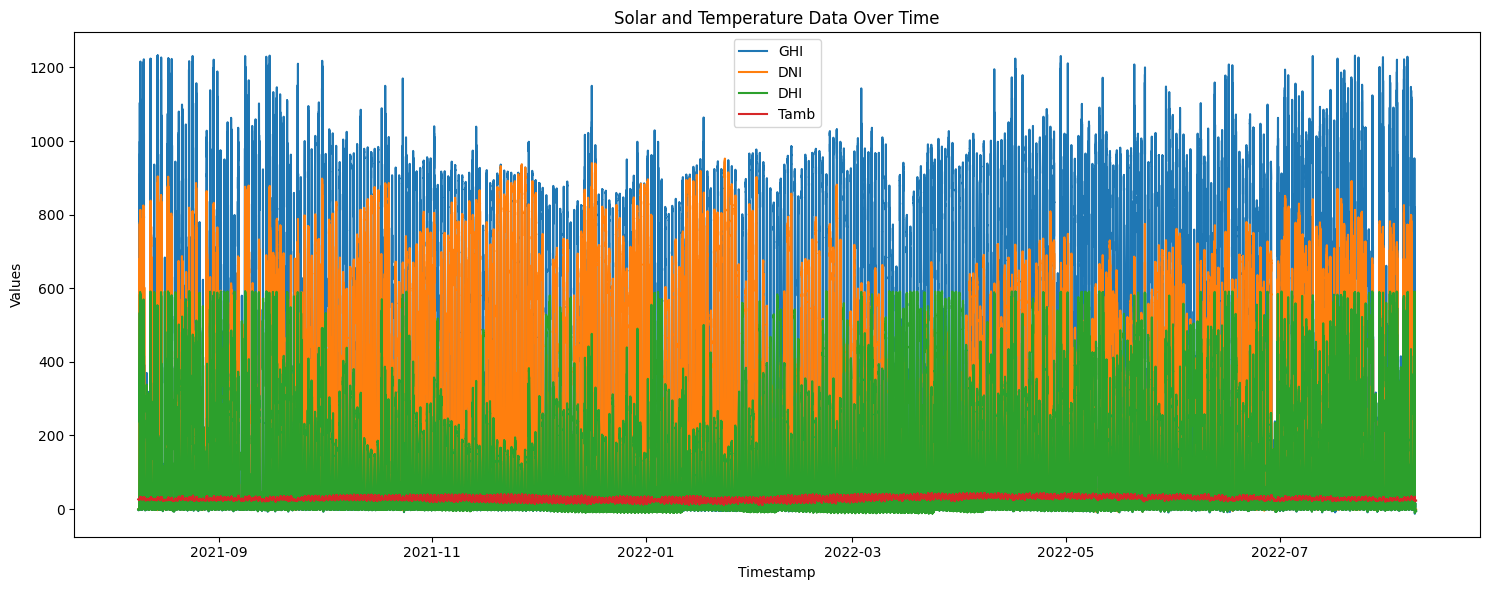

C:\Users\Mogassa\AppData\Local\Temp\ipykernel_15288\32448821.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df[columns_to_plot].resample('H').mean()  # resample by hour


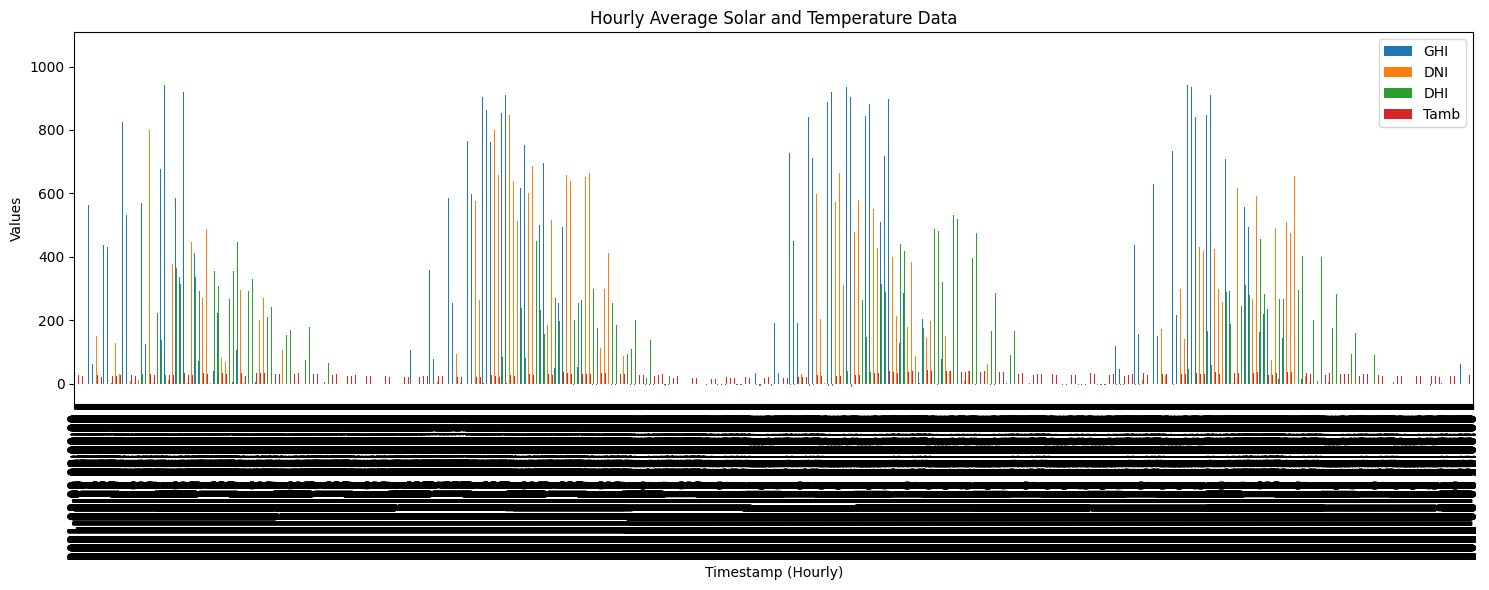

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load cleaned dataset
df = pd.read_csv(r"D:\Python\Week_01\Assignment\solar-challenge-week0\data\benin_clean.csv")

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set Timestamp as index for better plotting
df.set_index('Timestamp', inplace=True)

# Columns to plot
columns_to_plot = ['GHI', 'DNI', 'DHI', 'Tamb']

# --- Line chart ---
plt.figure(figsize=(15, 6))
for col in columns_to_plot:
    plt.plot(df.index, df[col], label=col)

plt.title("Solar and Temperature Data Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.legend()
plt.tight_layout()
plt.show()

# --- Optional: Bar chart (aggregated for better readability) ---
# e.g., hourly average for solar data
df_hourly = df[columns_to_plot].resample('h').mean()  # resample by hour

df_hourly.plot(kind='bar', figsize=(15,6))
plt.title("Hourly Average Solar and Temperature Data")
plt.xlabel("Timestamp (Hourly)")
plt.ylabel("Values")
plt.tight_layout()
plt.show()
